Missing values per column:
 timestamp         0
road_id           0
temperature_c     0
humidity_pct      0
precip_mm         0
aqi               0
weekday           0
is_weekend        0
is_holiday        0
event_flag        0
road_work         0
traffic_volume    0
traffic_lag_1     0
traffic_lag_2     0
hour              0
minute            0
road_id_cat       0
dtype: int64

Traffic volume stats:
 count    15000.000000
mean       113.423120
std         49.108688
min          9.200000
25%         76.200000
50%        104.700000
75%        144.300000
max        357.100000
Name: traffic_volume, dtype: float64


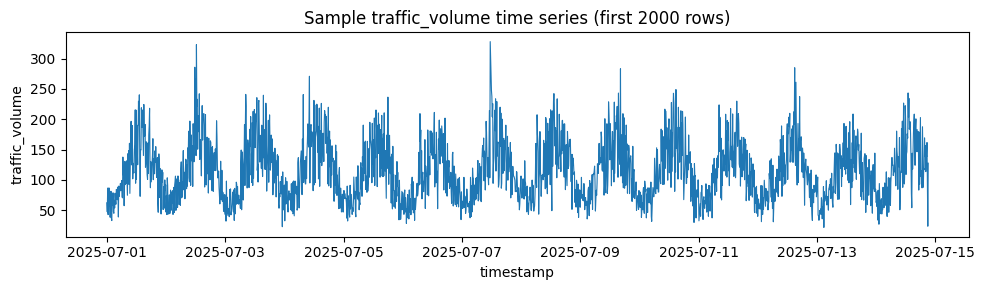


Training rows: 12750, Testing rows: 2250

Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

Test RMSE: 15.799
Test R^2: 0.913


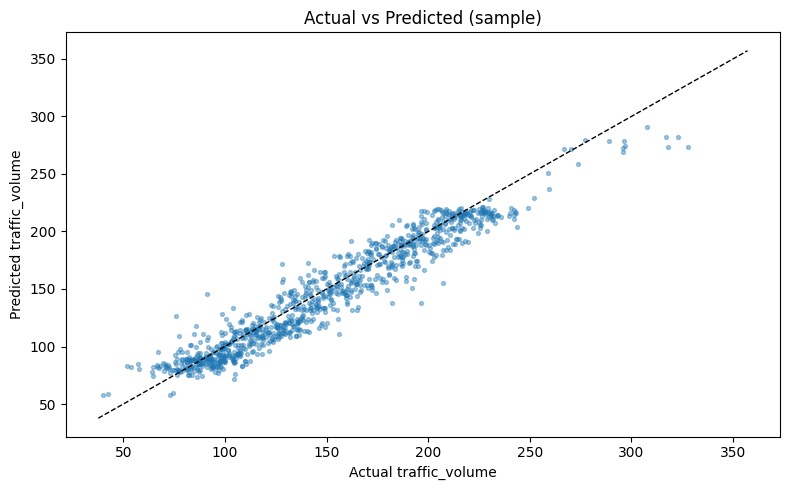

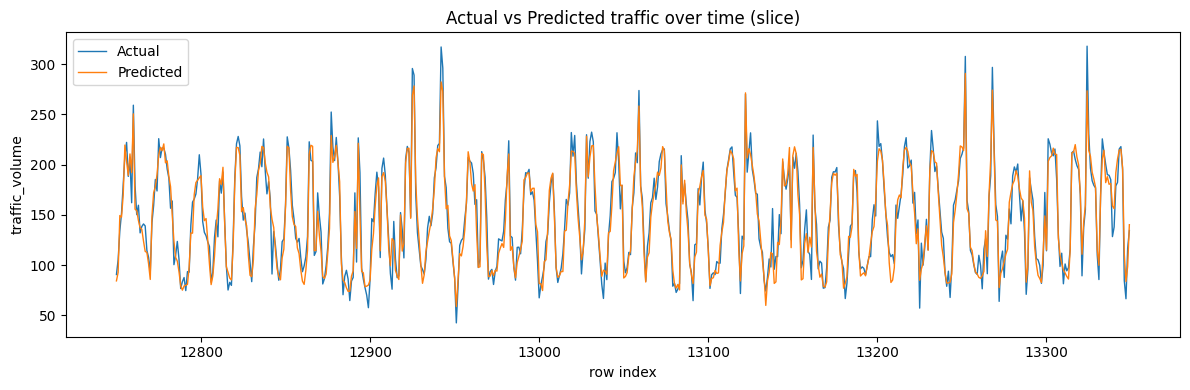

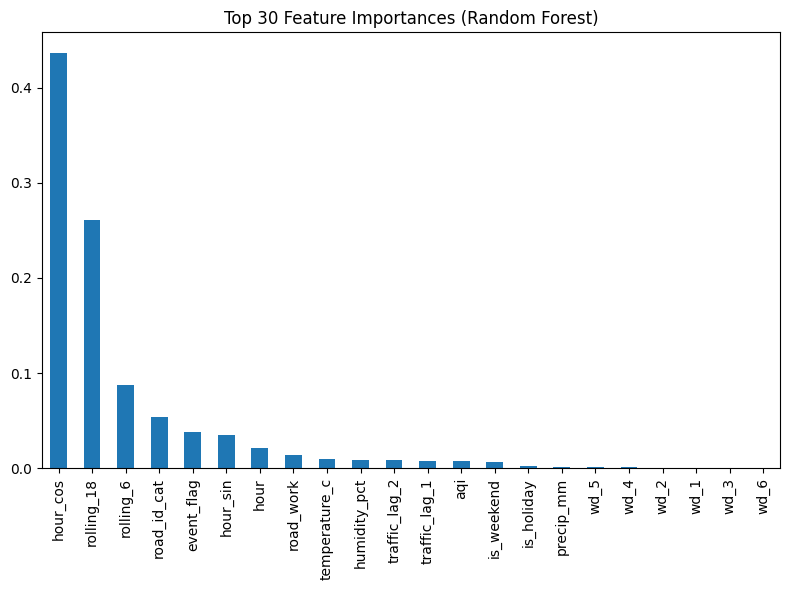


Saved sample data to data/synthetic_smartcity_sample.csv


In [1]:
# smart_city_intelligence_hub.py
# Run in Python 3.9+ with scikit-learn, pandas, numpy, matplotlib installed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import os
import random
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 1) Synthetic dataset generation
# ----------------------------
def generate_synthetic_city_data(n_rows=20000, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    # Generate continuous timestamps over 90 days at 10-minute resolution approx
    start = datetime(2025, 7, 1, 0, 0, 0)
    timestamps = [start + timedelta(minutes=10*i) for i in range(n_rows)]
    # 10 unique road segments (ids)
    road_ids = np.random.choice([f"R{str(i).zfill(2)}" for i in range(1, 11)], size=n_rows)
    # basic weather variables (use sinusoidal + noise to mimic diurnal)
    hours = np.array([t.hour + t.minute/60.0 for t in timestamps])
    temp = 20 + 8*np.sin(2 * np.pi * (hours - 6) / 24) + np.random.randn(n_rows)*1.8  # °C
    humidity = 60 + 20*np.cos(2 * np.pi * (hours) / 24) + np.random.randn(n_rows)*5
    precipitation = np.random.choice([0, 0, 0, 0.1, 0.5, 1.2], size=n_rows, p=[0.7,0.15,0.05,0.06,0.03,0.01])
    # air quality index baseline and variations
    base_aqi = 50 + (np.random.randn(n_rows) * 10).astype(float)
    # weekend flag, holiday (random small fraction)
    weekday = np.array([t.weekday() for t in timestamps])  # 0=Mon
    is_weekend = (weekday >= 5).astype(int)
    is_holiday = np.random.choice([0,1], size=n_rows, p=[0.995,0.005])
    # special events increase traffic at certain times
    event_flag = np.zeros(n_rows, dtype=int)
    for i in range(100):  # inject 100 events
        idx = np.random.randint(0, n_rows-10)
        event_flag[idx: idx+6] = 1  # ~one hour of extra traffic
    # road work flag (rare)
    road_work = np.random.choice([0,1], size=n_rows, p=[0.98,0.02])

    # base traffic by hour + road id multiplier + weekend/holiday/event effects
    # each road has a capacity factor
    road_capacity = {f"R{str(i).zfill(2)}": (0.6 + 0.1* i) for i in range(1, 11)}
    traffic_base_hour = 100 * (1 + 0.6*np.sin(2*np.pi*(hours-7)/24) + 0.2*np.sin(2*np.pi*(hours-17)/24))
    traffic_volume = []
    for i in range(n_rows):
        rid = road_ids[i]
        cap = road_capacity[rid]
        vol = traffic_base_hour[i] * cap
        # modify for weather: rain reduces speed but could increase measured density; we'll slightly increase volume variance
        vol *= (1 + 0.05*precipitation[i])
        # events bump
        vol *= (1 + 0.45*event_flag[i])
        # weekends slightly lower for commuting roads but higher in leisure hours
        if is_weekend[i]:
            vol *= 0.9
        # holidays lower traffic
        if is_holiday[i]:
            vol *= 0.7
        # road work reduces capacity
        if road_work[i]:
            vol *= 0.6
        # randomness
        vol = vol + np.random.randn()*10 + base_aqi[i]*0.02
        # ensure positive
        traffic_volume.append(max(5, vol))

    data = pd.DataFrame({
        "timestamp": timestamps,
        "road_id": road_ids,
        "temperature_c": np.round(temp, 2),
        "humidity_pct": np.round(humidity, 1),
        "precip_mm": precipitation,
        "aqi": np.round(base_aqi + (0.3*precipitation*20), 1),
        "weekday": weekday,
        "is_weekend": is_weekend,
        "is_holiday": is_holiday,
        "event_flag": event_flag,
        "road_work": road_work,
        "traffic_volume": np.round(traffic_volume, 1)
    })

    # Add lag features: previous 1 and 2 periods (assume 10-minute intervals)
    data['traffic_lag_1'] = data['traffic_volume'].shift(1).fillna(method='bfill')
    data['traffic_lag_2'] = data['traffic_volume'].shift(2).fillna(method='bfill')

    # Add hour and minute features
    data['hour'] = data['timestamp'].dt.hour
    data['minute'] = data['timestamp'].dt.minute

    # Encode road id as categorical numeric mapping (we will one-hot later or use target encoding)
    data['road_id_cat'] = data['road_id'].astype('category').cat.codes

    return data

# Generate dataset
df = generate_synthetic_city_data(n_rows=15000, seed=123)

# ----------------------------
# 2) Basic cleaning & quick EDA
# ----------------------------
# Check missing values
print("Missing values per column:\n", df.isna().sum())

# Quick distributions
print("\nTraffic volume stats:\n", df['traffic_volume'].describe())

# Plot simple time sample to visualize traffic trend (first 2000 rows)
plt.figure(figsize=(10,3))
plt.plot(df['timestamp'].iloc[:2000], df['traffic_volume'].iloc[:2000], linewidth=0.8)
plt.title('Sample traffic_volume time series (first 2000 rows)')
plt.xlabel('timestamp'); plt.ylabel('traffic_volume')
plt.tight_layout()
plt.show()

# ----------------------------
# 3) Feature engineering
# ----------------------------
# We'll create cyclical hour features for better learning (sin/cos)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Rolling features per road segment: rolling mean of traffic for last 6 and 18 intervals (approx 1 hour and 3 hours)
df = df.sort_values(['road_id','timestamp']).reset_index(drop=True)
df['rolling_6'] = df.groupby('road_id')['traffic_volume'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
df['rolling_18'] = df.groupby('road_id')['traffic_volume'].transform(lambda x: x.rolling(window=18, min_periods=1).mean())

# Drop columns we won't use directly
drop_cols = ['timestamp', 'road_id', 'minute']  # keep road_id_cat instead of string road_id
df_model = df.drop(columns=drop_cols)

# ----------------------------
# 4) Prepare training data
# ----------------------------
# Define features and target
target_col = 'traffic_volume'
features = [c for c in df_model.columns if c != target_col]

# Split train/test by time to simulate real-world forecasting (last 15% as test)
df_model = df_model.reset_index(drop=True)
n = len(df_model)
split_idx = int(n * 0.85)
train = df_model.iloc[:split_idx].copy()
test = df_model.iloc[split_idx:].copy()

X_train = train[features]
y_train = train[target_col]
X_test = test[features]
y_test = test[target_col]

print(f"\nTraining rows: {len(X_train)}, Testing rows: {len(X_test)}")

# Scale numeric features where appropriate for some models (not required by RandomForest, but good practice)
numeric_cols = ['temperature_c','humidity_pct','precip_mm','aqi','traffic_lag_1','traffic_lag_2','rolling_6','rolling_18']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# One-hot encode weekday (small cardinality)
X_train = pd.get_dummies(X_train, columns=['weekday'], prefix='wd', drop_first=True)
X_test = pd.get_dummies(X_test, columns=['weekday'], prefix='wd', drop_first=True)
# Ensure same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ----------------------------
# 5) Model training: Random Forest Regressor with simple hyperparameter tuning
# ----------------------------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Use a small GridSearch for demonstration; in production use more folds/time-aware CV
grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=0)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("\nBest params:", grid.best_params_)

# ----------------------------
# 6) Evaluation
# ----------------------------
y_pred = best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"\nTest RMSE: {rmse:.3f}")
print(f"Test R^2: {r2:.3f}")

# Plot Actual vs Predicted (sample)
plt.figure(figsize=(8,5))
plt.scatter(y_test.iloc[:1000], y_pred[:1000], alpha=0.4, s=8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1)
plt.xlabel('Actual traffic_volume')
plt.ylabel('Predicted traffic_volume')
plt.title('Actual vs Predicted (sample)')
plt.tight_layout()
plt.show()

# Plot time series slice (actual vs predicted)
plt.figure(figsize=(12,4))
idxs = y_test.index[:600]  # take a chunk
plt.plot(idxs, y_test.iloc[:600].values, label='Actual', linewidth=1)
plt.plot(idxs, y_pred[:600], label='Predicted', linewidth=1)
plt.legend()
plt.title('Actual vs Predicted traffic over time (slice)')
plt.xlabel('row index')
plt.ylabel('traffic_volume')
plt.tight_layout()
plt.show()

# Feature importance
importances = pd.Series(best.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
plt.figure(figsize=(8,6))
importances.plot(kind='bar')
plt.title('Top 30 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Save a small sample of the dataset to CSV for repository demo
os.makedirs('data', exist_ok=True)
df_sample = df.head(2000)
df_sample.to_csv('data/synthetic_smartcity_sample.csv', index=False)
print("\nSaved sample data to data/synthetic_smartcity_sample.csv")
